In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# 1. Setup

In [2]:
import numpy as np
import torch 
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt 

from mermaidseg.datasets.dataset import MermaidDataset
from mermaidseg.visualization import get_legend_elements

In [3]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

# 2. Data

In [4]:
dataset = MermaidDataset()

In [5]:
len(dataset)

1879

In [9]:
dataset.df_images

,image_id,region_id,region_name
0,00059a47-03b8-47f3-adf6-3ab5616922cf,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
25,0032dba6-8357-42e2-bace-988f99032286,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
50,004ed958-bdd4-453d-83ed-bf773c78bfc8,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
75,0055fc63-bcce-485b-bb3b-5384c08ad87f,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
100,00a8171e-32e2-48a5-91b1-74095feb4713,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
...,...,...,...
46850,ff92aad1-5d3b-4007-9a66-b63afea26eba,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
46875,ff9ebe40-6194-4672-86fd-db7cc531fdbd,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
46900,ffa620dd-311c-4819-9686-2a93d404f96d,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
46925,ffc74048-7f40-470a-8047-28b7294bc317,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific


In [10]:
dataset.df_annotations

,id,image_id,point_id,row,col,benthic_attribute_id,benthic_attribute_name,growth_form_id,growth_form_name,updated_on,region_id,region_name
0,adf9f72c-f498-454b-b4c2-d3cb6a2d1c5f,00059a47-03b8-47f3-adf6-3ab5616922cf,44044125-e1b8-4580-8531-acaf18a66935,457,467,30a987e9-b420-4db6-a83a-a1f7cabd14fb,Soft coral,None,None,2025-08-26 14:55:15.009823+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
1,0e97b960-cc38-49ed-91c6-f760f1eff354,00059a47-03b8-47f3-adf6-3ab5616922cf,e8c950a2-c37f-4f5e-8797-3f2d244257b6,457,934,b76bca12-884b-4404-bb9f-97d505b0fe58,Sand,None,None,2025-08-26 14:55:15.039272+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
2,1823ca56-edac-459e-b009-46c390f64afe,00059a47-03b8-47f3-adf6-3ab5616922cf,766bd109-c9f7-4489-8215-f2a46ffd9419,457,1401,d9086647-3a82-4634-97bc-6e10347af39b,Bare substrate,None,None,2025-08-26 14:55:15.085659+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
3,dc9d3b2d-b9f9-4a46-a208-790b5c3b2ec3,00059a47-03b8-47f3-adf6-3ab5616922cf,6aaaea05-f005-4e3e-a9bf-d6702e0b7736,457,1868,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,2025-08-26 14:55:15.133907+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
4,9bde5850-bb38-4ca3-88b3-43799f53f0ea,00059a47-03b8-47f3-adf6-3ab5616922cf,bed04244-e299-4eec-b9b7-05e15dbf5a75,457,2335,ed2332ed-0762-45fb-87a3-d315e218faf1,Rubble,None,None,2025-08-26 14:55:15.181096+00:00,1d31d9ea-e78d-438b-8667-0d63d1aba257,Western Indo-Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...
46970,6274d37d-c4e9-4d35-9a87-af56fd9bbe18,ffe95df7-2645-4529-9ae1-0fd2fe504056,07aae142-0fe3-4f74-9689-d1cd6c53519f,4060,928,995f68d0-2dec-4e22-916a-cf1f44c1663b,Millepora,None,None,2025-08-03 07:15:11.423723+00:00,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
46971,21cb4fea-7e62-4384-ad24-20e928c6b350,ffe95df7-2645-4529-9ae1-0fd2fe504056,be972547-f340-4eef-8010-262d7b97e9b6,4060,1856,995f68d0-2dec-4e22-916a-cf1f44c1663b,Millepora,None,None,2025-08-03 07:15:11.444918+00:00,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
46972,02ed86ed-8fb9-44e5-bbca-aa3ff22ebb73,ffe95df7-2645-4529-9ae1-0fd2fe504056,555325a4-cc9d-4fa2-bf4d-bec4920a1118,4060,2784,b76bca12-884b-4404-bb9f-97d505b0fe58,Sand,None,None,2025-08-03 07:15:11.466881+00:00,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific
46973,3e692109-4b70-4db1-b814-794e34ed8384,ffe95df7-2645-4529-9ae1-0fd2fe504056,f21b8046-c2fc-4484-ac7a-2260f296b4f1,4060,3712,b76bca12-884b-4404-bb9f-97d505b0fe58,Sand,None,None,2025-08-03 07:15:11.490063+00:00,983267a0-7349-4d3e-a23e-fb9353ca8ba5,Central Indo-Pacific


In [6]:
image, mask, annotations = dataset[0]

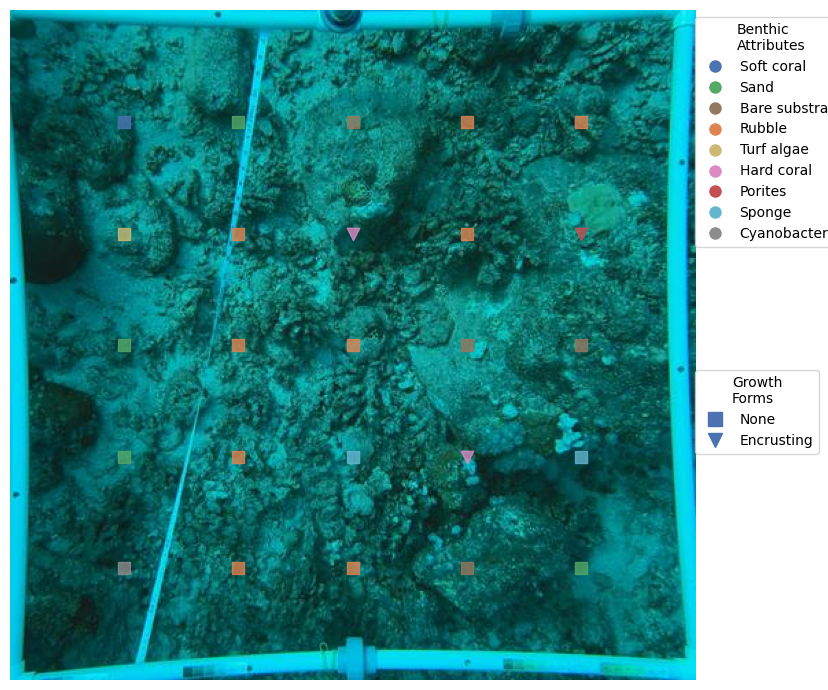

In [7]:
fig, ax = plt.subplots(figsize = (8.5, 7), layout = "tight")
plt.imshow(image)
for i, annotation in annotations.iterrows():
    plt.scatter(annotation['col'], annotation['row'], 
                color=annotation["benthic_color"],
                marker=annotation["growth_form_marker"], 
                s=80,
                alpha=0.8)

benthic_legend_elements, growth_legend_elements = get_legend_elements(annotations)

first_legend = plt.legend(handles=benthic_legend_elements, bbox_to_anchor=(0.99, 1), 
                            loc='upper left', title='Benthic\nAttributes')
plt.gca().add_artist(first_legend)
plt.legend(handles=growth_legend_elements, bbox_to_anchor=(0.99, 0.4), 
          loc='center left', title='Growth\nForms')

plt.axis("off")
plt.show()

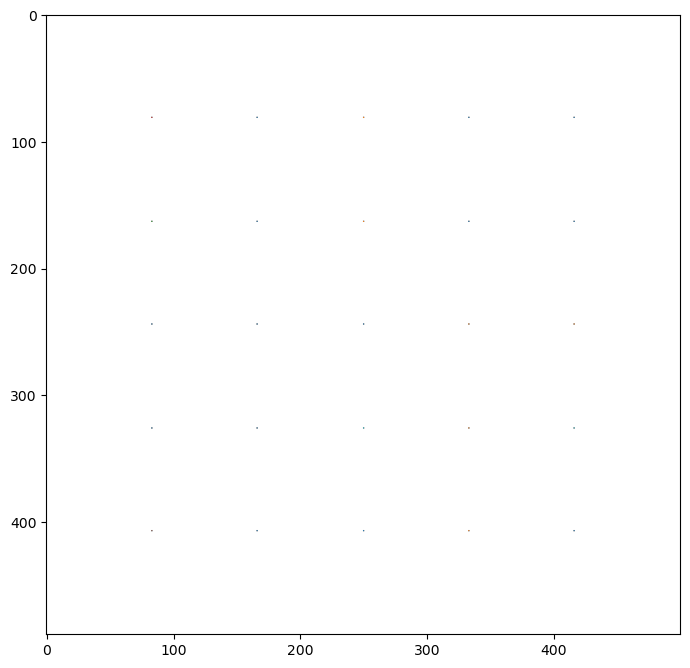

In [7]:
fig, ax = plt.subplots(figsize = (7, 7), layout = "tight")
plt.imshow(np.where(mask>0, mask, np.nan), cmap = "tab10")
plt.show()

In [12]:
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2, drop_last=True)
len(data_loader)

939